In [1]:
#!pip install -U langgraph langchain_openai langchain_community langchain-google-vertexai langchain-google-genai chromadb langgraph pypdf langchain_google_community unstructured[pdf] streamlit sentence-transformers

In [ ]:
#!sudo apt update

In [ ]:
#!sudo apt install python3-pip

In [ ]:
#!pip3 install --upgrade pip setuptools wheel

In [ ]:
#Libraries to be installed in addition on GCP
#!sudo apt-get update
#!apt-get install poppler-utils
#! apt install tesseract-ocr
#! apt install libtesseract-dev

In [ ]:
#!python --version

#Import Libraries

In [1]:
import pandas as pd
from google.cloud import bigquery
import sqlite3
#import streamlit as st
from langchain_community.tools.sql_database.tool import (
    InfoSQLDatabaseTool,
    ListSQLDatabaseTool,
    QuerySQLCheckerTool,
    QuerySQLDataBaseTool,
)
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_google_vertexai import ChatVertexAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.document_loaders import WebBaseLoader, PyPDFLoader
from langchain_google_community import GCSDirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_google_vertexai import VertexAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from langchain.agents import AgentType, Tool, initialize_agent, AgentExecutor
from typing import Union, Sequence, TypedDict, Annotated, List, Dict, Optional,Tuple
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from typing_extensions import TypedDict, Literal
import functools
import operator
from langgraph.graph import END, StateGraph, START, MessagesState


# Load Non-Structured Data

In [2]:
import os
os.environ["GOOGLE_API_KEY"] ='YOUR GOOGLE API'

In [3]:
loader = GCSDirectoryLoader(project_name="kw-data-science-playground", bucket="kw-data-science-scratch", prefix="fred/KB")

documents = loader.load()

print(len(documents))


2


In [4]:
def split_docs(documents,chunk_size=1000,chunk_overlap=200):
  text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
  docs = text_splitter.split_documents(documents)
  return docs

docs = split_docs(documents)
print(len(docs))


815


In [5]:
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain_google_genai import GoogleGenerativeAIEmbeddings

persist_directory = "chroma_db"
#embeddings= GoogleGenerativeAIEmbeddings(model="models/embedding-001")
embeddings = VertexAIEmbeddings(model_name="text-embedding-005")

vectordb = Chroma.from_documents(
    documents=docs, embedding=embeddings, persist_directory=persist_directory
)

retriever = vectordb.as_retriever()

In [6]:
# New
question = "Top 3 coaching programs tagged to Full Cap?"
docs = vectordb.similarity_search(question)
len(docs)

4

In [7]:
# New
docs[0]

Document(metadata={'source': 'gs://kw-data-science-scratch/fred/KB/coaching_cap.pdf'}, page_content='Full Cap - Breakthrough Coaching Program - Agent ACH Canadian Full Cap - Coaches Coaching - BOLD Head Coaching Program Full Cap - Biweekly Life Coaching Program Full Cap - Coaches Coaching - MAPS Coach Full Cap - Executive Mastery Coaching Program - Agent ACH Canadian Full Cap - The Language of Sales (69) Full Cap - Hold - Mastery Leadership CC Full Cap - 1x1 Coach - Cadre Program Full Cap - 30-60-90: Productivity Coach Full Cap - Mastery Coaching Contract - Leadership ACH Full Cap - Hold - Executive Mastery Agent Full Cap - Fund My Mission Coaching Agreement Full Cap - Life Coaching Program - Release with MER Full Cap - Executive Mastery Coaching Program - Agent COMBO Full Cap - Hold - Mastery Leadership - No Fee CC Full Cap - Pivot 2020 Mastery Coaching Contract Agent - May Full Cap - Weekly Life Coaching Program - Support Full Cap - 30-60-90: Listing Agent Full Cap - Hold - Mastery A

In [8]:
# Convert loaded documents into strings by concatenating their content
# and ignoring metadata
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Load Structured Data

In [9]:
client = bigquery.Client()

In [10]:
QUERY1 = (
'''
SELECT kw_uid as kw_uid,
heatseeker,
CASE
  when heatseeker > 0.1374 THEN 1
  else 0
END AS FLAGGED_CHURN_REALTORS,
cap as CAP_SEGMENT,
units_last_12 as SOLD_UNITS
FROM `data-lake-prod-pres-2c917b19.people.agent_retention__internal_agent_targets_tbl`
'''
)
df_c = client.query_and_wait(QUERY1).to_dataframe()

In [11]:
df_c[df_c.duplicated(['kw_uid'], keep=False)]

,kw_uid,heatseeker,FLAGGED_CHURN_REALTORS,CAP_SEGMENT,SOLD_UNITS
240,751323,0.205,1,Zero,0E-9
317,2000011024,0.250,1,None,0E-9
337,2000025397,0.236,1,None,0E-9
419,2000012472,0.208,1,None,0E-9
437,867261,0.212,1,Zero,1.000000000
...,...,...,...,...,...
75941,897329,0.189,1,None,1.000000000
75950,833346,0.189,1,Zero,0E-9
75954,2000040823,0.189,1,None,0E-9
76001,796994,0.189,1,Zero,0E-9


In [12]:
df_c = df_c.drop_duplicates(subset='kw_uid', keep="first")

In [13]:
df_c['kw_uid'] = pd.to_numeric(df_c['kw_uid'], errors='coerce')

In [14]:
QUERY2 = (
'SELECT distinct kw_uid, first_name, last_name, luxury, commercial, land, military ,maps_client, maps_mastery_client,  FROM `data-lake-prod-pres-2c917b19.people.ams__person_details_tbl` where active = 1 and country_id = 235 and person_type = 1'
)
df_a = client.query_and_wait(QUERY2).to_dataframe()

In [15]:
QUERY3 = (
'''
SELECT distinct kw_uid,
max(case when source = "Designs" THEN count end) as Designs,
max(case when source = "SmartPlans" THEN count end) as SmartPlans,
max(case when source = "Tasks" THEN count end) as Tasks,
max(case when source = "Interactions" THEN count end) as Interactions,
max(case when source = "Referrals" THEN count end) as Referrals,
max(case when source = "Campaigns" THEN count end) as Campaigns,
max(case when source = "Opportunities" THEN count end) as Opportunities,
max(case when source = "Contacts" THEN count end) as Contacts
FROM `data-lake-prod-pres-2c917b19.bi_rd.command_activity_fixed`
WHERE type != 'deleted' and date >= '2024-01-01'
group by kw_uid
;
'''
)
df_u = client.query_and_wait(QUERY3).to_dataframe()

In [16]:
# Replace null values with 0
df_u.fillna(0, inplace=True)

In [17]:
df_u[df_u.duplicated(['kw_uid'], keep=False)]

,kw_uid,Designs,SmartPlans,Tasks,Interactions,Referrals,Campaigns,Opportunities,Contacts


In [18]:
df_u['kw_uid'] = pd.to_numeric(df_u['kw_uid'], errors='coerce')

In [19]:
QUERY4 = (
'''
WITH contacts_data_set AS (
  SELECT c.*
  FROM (SELECT cs.*, owner.id as owner_id, author.created_by as created_by
            , CASE WHEN p.type = 'CLAIMED' THEN p.granted_to END as claimed_by
            , p.granted_to
      FROM `data-lake-prod-pres-2c917b19.contacts.contacts_snapshot` cs LEFT JOIN UNNEST(permissions) p) c
  WHERE c.archived_date IS NULL AND c.deleted_at IS NULL -- active (not deleted or archived) contacts only
)

, primary_assignee AS (
  SELECT c._id
        , CASE WHEN owner.type = 'AGENT' THEN owner.id
              WHEN claimed_by IS NOT NULL THEN claimed_by
              WHEN in_lead_route = true THEN NULL
              WHEN granted_count = 1 THEN granted_to
              ELSE created_by END as kw_uid -- primary assignee
  FROM contacts_data_set c
        JOIN (SELECT _id, COALESCE(COUNT(DISTINCT granted_to),0) as granted_count FROM contacts_data_set GROUP BY 1) a ON c._id = a._id
)

, contacts_per_kwuid AS (
  SELECT kw_uid, COUNT(DISTINCT _id) as active_contact_count
  FROM primary_assignee
  GROUP BY ALL
)

SELECT *
FROM contacts_per_kwuid
'''
)
df_co = client.query_and_wait(QUERY4).to_dataframe()

In [20]:
df_co['kw_uid'] = pd.to_numeric(df_co['kw_uid'], errors='coerce')

In [21]:
merged_df = df_c.merge(df_a, on='kw_uid').merge(df_u, on='kw_uid').merge(df_co, on='kw_uid')

In [32]:
merged_df.fillna(0, inplace=True)

# Inject DataFrame into DB

In [33]:
connection = sqlite3.connect("realtors.db")
connection.execute("DROP TABLE realtors")

In [34]:
merged_df_str = merged_df.applymap(str)

<ipython-input-34-be2c4912a81e>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  merged_df_str = merged_df.applymap(str)


In [35]:
merged_df_str.to_sql(name="realtors", con=connection)

49495

In [36]:
db = SQLDatabase.from_uri("sqlite:///realtors.db")

In [37]:
#llm = ChatVertexAI(model="gemini-1.5-flash-002")
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-002", temperature=0.1)
#llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", temperature=0.5)

In [38]:
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

# Set-up SQL Agent

In [39]:
MSSQL_AGENT_SUFFIX_WITH_MEMORY= """While generating SQL for the above query, pay attention to the below:



- General Instructions:

  - Do not use any LIMIT statements in SQL.
  - Round answers to two decimal places.
  - Avoid complicated SQL queries such as those involving division within a query.
  - Perform operations step by step.
  - Pay attention to all conditions mentioned in the query. Do not infer conditions.
  - For questions on share or market share, use column="Amount" unless stated otherwise explicitly.
  - YTD or ytd = Year to Date
   - Don't assume year as current year unless indicated so. Take data for all years unless its indicated to use a specific year"""

In [40]:
sql_agent_executor = create_react_agent(llm,tools=toolkit.get_tools(),state_modifier=MSSQL_AGENT_SUFFIX_WITH_MEMORY)

In [41]:
#Test a qeury with the SQL agent
query="How many realtors are present in the database and what is the average number of contacts?"

events = sql_agent_executor.stream(
     {"messages": [HumanMessage(content=query)]},
     stream_mode="values",
)

for event in events:
   event["messages"][-1].pretty_print()
   message_content= event["messages"][-1].content
   if "Answer:" in message_content:
      final_answer=message_content.split("Answer:",1)[1].strip()

================================ Human Message =================================

How many realtors are present in the database and what is the average number of contacts?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (41a3ec23-0548-4a73-a584-68f7dd57ef56)
 Call ID: 41a3ec23-0548-4a73-a584-68f7dd57ef56
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

realtors
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (6e092e97-2409-4295-9361-701533b57659)
 Call ID: 6e092e97-2409-4295-9361-701533b57659
  Args:
    table_names: realtors
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE realtors (
	"index" INTEGER, 
	kw_uid TEXT, 
	heatseeker TEXT, 
	"FLAGGED_CHURN_REALTORS" TEXT, 
	"CAP_SEGMENT" TEXT, 
	"SOLD_UNITS" TEXT, 
	first_name TEXT, 


# Set-up RAG Agent

In [42]:
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """
CONTEXT:
{context}

QUERY:
{question}

Use only the provided context information to form your response. If an answer can not be found within the provided context information respond with 'The answer could not be found in the provided context.".

"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

In [43]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser

#rag_chain = (
#    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
#    | rag_prompt | llm | StrOutputParser()
#)

from langchain_core.runnables import RunnablePassthrough

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | rag_prompt
    | llm
    | StrOutputParser()
)

In [44]:
# rag_chain.invoke({"question" : "What are some of the most popular coaching programs in the Full Cap status?"})
rag_chain.invoke("What are some of the most popular coaching programs in the Full Cap status?")

'Based on the provided text, the most frequently mentioned Keller Williams coaching programs with "Full Cap" status are:\n\n* Mastery Coaching Program\n* Breakthrough Coaching Program\n* Performance Agent Full Cap\n'

In [45]:
from typing import Annotated, List, Tuple, Union
from langchain_core.tools import tool

@tool
def retrieve_information(
    query: Annotated[str, "query to ask the retrieve information tool"]
    ):
  """Use Retrieval Augmented Generation to retrieve information."""
  #return rag_chain.invoke({"question" : query})
  return rag_chain.invoke(query)

In [46]:
tools = [retrieve_information]

# Utilities

In [ ]:
## Structured Output Enforcement
#class RealterInfoResponse(BaseModel):
#    """Respond to the user with this"""

#    AGENT_ACHIEVEMENT_DESCRIPTION_AS_WAS: str = Field(description="What cap segment the realtor is in")
#    first_name: str = Field(description="First name of the realtor")
#    Contacts: float = Field(description="Number of contacts")
#    SmartPlans: float = Field(description="Usage of smartplans")



In [ ]:
## Structured Output Enforcement
#model_with_tools = llm.bind_tools([RealterInfoResponse])

In [40]:
# The agent state is the input to each node in the graph
class AgentState(MessagesState):
    # The 'next' field indicates where to route to next
    next: str
    # Structured Output Enforcement
    #final_response: RealterInfoResponse

In [47]:
members = ["PDF_analyst", "Sql_agent"]
options = ["FINISH"] + members

# The agent state is the input to each node in the graph
class AgentState(MessagesState):
    # The 'next' field indicates where to route to next
    next: str


def make_supervisor_node(llm: llm, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(BaseModel):
        """Worker to route to next. If no workers needed, route to FINISH."""

        #next: Literal["FINISH","PDF_Analyst","Sql_agent"]
        next: Literal[(*options,)]

    def supervisor_node(state: MessagesState) -> MessagesState:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        next_ = response.next
        if next_ == "FINISH":
            next_ = END

        return {"next": next_}

    return supervisor_node

# Initialize the Research Agents

In [48]:
rag_agent = create_react_agent(llm, tools=tools, state_modifier="You should provide RAG search.")
#rag_node = functools.partial(agent_node, agent=rag_agent, name="PDF_analyst")

def rag_node(state: AgentState) -> AgentState:
    result = rag_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="PDF_Analyst")
        ]
    }


sql_agent = create_react_agent(llm, tools=toolkit.get_tools(), state_modifier=MSSQL_AGENT_SUFFIX_WITH_MEMORY)
#sql_node = functools.partial(agent_node, agent=sql_agent, name="Sql_agent")
def sql_node(state: AgentState) -> AgentState:
    result = sql_agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name="Sql_agent")]
    }

research_supervisor_node = make_supervisor_node(llm, ["PDF_Analyst", "Sql_agent"])



# Create the Research Workflow

In [49]:
research_builder = StateGraph(MessagesState)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("PDF_Analyst", rag_node)
research_builder.add_node("Sql_agent", sql_node)

# Define the control flow
research_builder.add_edge(START, "supervisor")
# We want our workers to ALWAYS "report back" to the supervisor when done
research_builder.add_edge("PDF_Analyst", "supervisor")
research_builder.add_edge("Sql_agent", "supervisor")
# Add the edges where routing applies
research_builder.add_conditional_edges("supervisor", lambda state: state["next"])

research_graph = research_builder.compile()

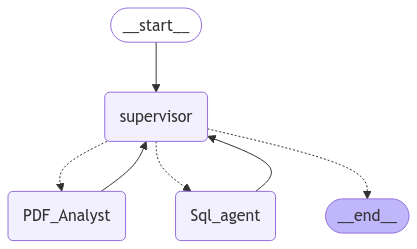

In [50]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

# Research Results

In [51]:
query = "What are the top 3 keller williams coaching programs tagged Full Cap?"

input_data = {"query": query}

for s in research_graph.stream(
    {
        "messages": [
            HumanMessage(content=input_data['query'])
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'PDF_Analyst'}}
----
{'PDF_Analyst': {'messages': [HumanMessage(content='I am sorry, I do not have access to real-time information, including specific details about Keller Williams coaching programs and their tags.  My knowledge about this topic is limited.  To find the top 3 Keller Williams coaching programs tagged "Full Cap," I recommend checking the official Keller Williams website or contacting them directly.\n', additional_kwargs={}, response_metadata={}, name='PDF_Analyst', id='1f3e8dfd-8acd-465c-9466-3fb3eac340d6')]}}
----
{'supervisor': {'next': '__end__'}}
----


In [52]:
query = "How many realtors are present in the database and what is the average count contacts?"

input_data = {"query": query}

for s in research_graph.stream(
    {
        "messages": [
            HumanMessage(content=input_data['query'])
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Sql_agent'}}
----
{'Sql_agent': {'messages': [HumanMessage(content='There are 49495 realtors in the database and the average number of contacts is 299.82.\n', additional_kwargs={}, response_metadata={}, name='Sql_agent', id='4084ad65-d154-48db-9780-9819351c35b6')]}}
----
{'supervisor': {'next': '__end__'}}
----


# Initialize the Writing Agents

In [53]:
def call_model(state: MessagesState):
    # add any logic to customize model system message etc here
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

builder_writer = StateGraph(MessagesState)
builder_writer.add_node(call_model)
builder_writer.add_edge(START, "call_model")

writer_graph = builder_writer.compile()

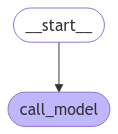

In [54]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        writer_graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [55]:
query = "Describe what a realtor does?"

input_data = {"query": query}

for s in writer_graph.stream(
    {
        "messages": [
            HumanMessage(content=input_data['query'])
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'call_model': {'messages': [AIMessage(content="A realtor, or real estate agent, acts as an intermediary between buyers and sellers of properties.  Their core responsibilities revolve around facilitating real estate transactions, which includes a wide range of activities:\n\n**For Sellers:**\n\n* **Listing Properties:**  Marketing properties for sale, including taking photos, writing descriptions, and determining a competitive listing price.\n* **Showing Properties:**  Conducting showings for prospective buyers, answering questions, and providing information about the property and the surrounding area.\n* **Negotiating Offers:**  Presenting offers to sellers, negotiating terms and conditions, and helping sellers make informed decisions.\n* **Managing Paperwork:**  Handling all the necessary paperwork involved in the sale, including contracts, disclosures, and closing documents.\n* **Marketing and Advertising:** Utilizing various marketing channels (online listings, open houses, etc.) t

# Add Layers

In [57]:
prompt_message_super="""You are a supervisor tasked with managing a conversation between the following workers: {{members_super}}.
Given the following user request, respond with the worker to act next. Each worker will perform a task and respond with their results and status. If the conversation is over, respond with 'FINISH'.

Create a nicely formatted example email for the first realtor that is identified as going to churn based upon the
        first kw_uid from the list. Make sure to adhere to the following:
        1. Address the realtor with the content of the "First Name" field.
        2. Indicate in which CAP segment the realtor is currently residing in.
        3. Recommend a couple of coaching programs that realtors are taking in the next CAP segment up.
          Suggest that if they are looking for something else suggest contacting their MAPS coach.
        4. If the number of active_contact_count from the realtor is less than 201 please call this out in that this has been proven out to be correlated with higher production.
        5. Evalaute if the realtor has any usage with SmartPlans and if 0 suggest the use of SmartPlans as a tool to engage with their contacts.
        6. Make sure it is a positive and constructive message.
        7. Sign off with The Keller Williams Team

 """

In [58]:
teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

In [59]:
def call_research_team(state: AgentState) -> AgentState:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return {
        "messages": [
            HumanMessage(content=response["messages"][-1].content, name="research_team")
        ]
    }


def call_paper_writing_team(state: AgentState) -> AgentState:
    response = writer_graph.invoke({"messages": state["messages"][-1]})
    return {
        "messages": [
            HumanMessage(content=response["messages"][-1].content, name="writing_team")
        ]
    }



In [60]:
# Define the graph.
super_builder = StateGraph(AgentState)
super_builder.add_node("supervisor_super", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

In [61]:
# Define the control flow
super_builder.add_edge(START, "supervisor_super")
# We want our teams to ALWAYS "report back" to the top-level supervisor when done
super_builder.add_edge("research_team", "supervisor_super")
super_builder.add_edge("writing_team", "supervisor_super")
# Add the edges where routing applies
super_builder.add_conditional_edges("supervisor_super", lambda state: state["next"])
super_graph = super_builder.compile()

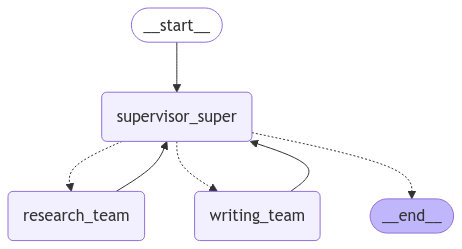

In [62]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [63]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", prompt_message_super)
        ],
    },
    {"recursion_limit": 150},
):
    print(s)
    print("---")

{'supervisor_super': {'next': 'research_team'}}
---
{'research_team': {'messages': [HumanMessage(content='Worker 3: I\'ve formatted the email and reviewed it. Here\'s the final version:\n\nSubject: Checking In and Sharing Some Helpful Resources\n\nHi John,\n\nI hope this email finds you well. I\'m writing to you today as part of our ongoing efforts to support your success here at Keller Williams. I see you\'re currently in the Silver CAP segment, and I wanted to share some resources that might help you advance to the next level.\n\nWe\'ve found that increased engagement with our coaching programs is strongly correlated with higher production. For the next CAP segment, I recommend exploring the "Lead Generation Strategies" and "Mastering Client Communication" workshops. If these don\'t quite fit your needs, please don\'t hesitate to reach out to your MAPS coach for personalized recommendations.\n\nYour current active contact count is 150. While this is a good number, we\'ve seen that ma